<a href="https://colab.research.google.com/github/showkami/FinViz/blob/main/FedOperationVisualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, date2num
import matplotlib.ticker as ticker
from time import sleep
from tqdm.notebook import tqdm
# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
import requests
from bs4 import BeautifulSoup
import pprint
from datetime import datetime, date, timedelta

# 準備

In [ ]:
def cnvt_time_12to24(string12):
    if string12[-2:] == 'AM':
        return string12[:5]
    elif string12[-2:] == 'PM':
        return str((int(string12[:2]) + 12) % 24) + string12[2:5]

## 各Fedオペの情報を集める

In [ ]:
num = 250  # 過去num回のオペを拾う。最高999回のよう
raw = requests.get(url=f'https://markets.newyorkfed.org/api/tsy/all/results/details/last/{num}.sdmx.xml')
soup = BeautifulSoup(raw.content, 'xml')

print(len(soup.find_all('out:Group')))
print('latest operation date:', soup.find_all('out:Group')[0]['operationDate'])
print('oldest operation date:', soup.find_all('out:Group')[-1]['operationDate'])

250
latest operation date: 2021-04-16
oldest operation date: 2020-04-17


In [ ]:
raw.content

b'<CrossSectionalData xmlns="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/message" xmlns:common="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/common" xmlns:compact="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/compact" xmlns:cross="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/cross" xmlns:generic="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/generic" xmlns:out="http://www.newyorkfed.org/xml/schemas/Outrights" xmlns:query="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/query" xmlns:structure="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/structure" xmlns:utility="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/utility" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.SDMX.org/resources/SDMXML/schemas/v1_0/message http://www.sdmx.org/data/SDMXMessage.xsd http://www.newyorkfed.org/xml/schemas/Outrights http://www.newyorkfed.org/xml/schemas/v3_0/outrightSchema.xsd">\n<Header>\n<ID>FRBNY_TREASURY_SECURITIES</ID>\n<Test>fa

In [ ]:
operationId_lst = []
operationDate_lst = []
maturity_range_start_lst = []
maturity_range_end_lst = []
total_submitted_amount_lst = []
total_purchase_amount_lst = []
weighted_average_maturity_lst = []

purchased_cusip_lst = []
purchased_maturity_lst = []
purchased_amount_lst = []
purchased_at_operationId_lst = []

for ope in soup.find_all('out:Group'):
    operationId = ope['operationId']
    operationDateTime = ope['operationDate'] + 'T' + cnvt_time_12to24(ope['closeTime'])
    operationDateTime = datetime.strptime(operationDateTime, '%Y-%m-%dT%H:%M')
    maturity_range_start = ope['maturityRangeStart']
    maturity_range_start = datetime.strptime(maturity_range_start, '%Y-%m-%d')
    maturity_range_start_lst.append(maturity_range_start)
    maturity_range_end = ope['maturityRangeEnd']
    maturity_range_end = datetime.strptime(maturity_range_end, '%Y-%m-%d')
    maturity_range_end_lst.append(maturity_range_end)
    total_submitted_amount = ope.find('out:totalAmountSubmitted')['totalParAmtSubmitted']
    total_submitted_amount = float(total_submitted_amount)
    total_submitted_amount_lst.append(total_submitted_amount)
    
    # 各オペで買った債券のデータベース作り
    total_purchase_amount = 0
    weighted_average_maturity = timedelta()
    for iss in ope.find_all('out:issue'):
        purchased_cusip_lst.append(iss['cusip'])
        purchased_at_operationId_lst.append(operationId)
        maturity = datetime.strptime(iss['securityDescription'][-8:], '%m/%d/%y')
        if iss['inclusion'] == 'true':
            purchased_maturity_lst.append(maturity)
            amount = int(iss['parAmountAccepted']) / 1e+6
            purchased_amount_lst.append(amount)
            total_purchase_amount += amount
            weighted_average_maturity += amount * (maturity - operationDateTime)
        else:
            purchased_maturity_lst.append(maturity)
            purchased_amount_lst.append(np.nan)
    weighted_average_maturity /= total_purchase_amount
    
    # このオペをオペデータベースに格納
    operationId_lst.append(operationId)
    operationDate_lst.append(operationDateTime)
    total_purchase_amount_lst.append(total_purchase_amount)
    weighted_average_maturity_lst.append(weighted_average_maturity.days / 365)
    del operationId, operationDateTime, total_purchase_amount, weighted_average_maturity

operations_db = pd.DataFrame({
    'datetime': operationDate_lst,
    'maturity_range_start': maturity_range_start_lst,
    'maturity_range_end': maturity_range_end_lst,
    'purchase_amount': total_purchase_amount_lst,
    'submitted_amount': total_submitted_amount_lst,
    'wam': weighted_average_maturity_lst
}, index=operationId_lst)
purchased_treasuries = pd.DataFrame({
        'cusip': purchased_cusip_lst,
        'opeid': purchased_at_operationId_lst,
        'maturity': purchased_maturity_lst,
        'amount': purchased_amount_lst
    })
del operationId_lst, operationDate_lst, total_purchase_amount_lst, weighted_average_maturity_lst, \
    purchased_cusip_lst, purchased_maturity_lst, purchased_amount_lst

In [ ]:
operations_db.assign(
    remaining_to_maturity_range_start=lambda df: (df['maturity_range_start'] - df['datetime']).astype('timedelta64[M]') / 12,
    remaining_to_maturity_range_end=lambda df: (df['maturity_range_end'] - df['datetime']).astype('timedelta64[M]') / 12,
).head(25)

datetime  ... remaining_to_maturity_range_end
OR 041221 1 2021-04-12 10:30:00  ...                       29.833333
OR 040921 2 2021-04-09 10:30:00  ...                       19.833333
OR 040821 2 2021-04-08 10:30:00  ...                        7.250000
OR 040721 2 2021-04-07 10:30:00  ...                        6.916667
OR 040621 2 2021-04-06 10:30:00  ...                       29.833333
OR 040521 2 2021-04-05 11:20:00  ...                        2.166667
OR 033121 2 2021-03-31 10:30:00  ...                       29.833333
OR 033021 2 2021-03-30 10:30:00  ...                       29.833333
OR 032921 2 2021-03-29 10:30:00  ...                        4.416667
OR 032521 2 2021-03-25 10:30:00  ...                       29.833333
OR 032421 2 2021-03-24 10:30:00  ...                        4.416667
OR 032321 2 2021-03-23 10:30:00  ...                       29.833333
OR 032221 2 2021-03-22 10:30:00  ...                       19.833333
OR 031921 2 2021-03-19 10:30:00  ...                        7.250000
OR 031821 2 2021-03-18 10:30:00  ...                       29.833333
OR 031621 1 2021-03-16 10:30:00  ...                        6.916667
OR 031521 2 2021-03-15 10:30:00  ...                       29.916667
OR 031221 1 2021-03-12 10:30:00  ...                        2.166667
OR 031021 2 2021-03-10 10:30:00  ...                       29.916667
OR 030921 1 2021-03-09 10:30:00  ...                       19.916667
OR 030821 2 2021-03-08 10:30:00  ...                       29.916667
OR 030521 2 2021-03-05 11:20:00  ...                        4.416667
OR 030421 2 2021-03-04 10:30:00  ...                       29.916667
OR 030321 2 2021-03-03 11:20:00  ...                        6.916667
OR 030221 2 2021-03-02 10:30:00  ...                       29.916667

[25 rows x 8 columns]

In [ ]:
purchased_treasuries

cusip        opeid   maturity  amount
0      912810QU5  OR 041221 1 2042-02-15     0.0
1      912810QX9  OR 041221 1 2042-08-15     0.0
2      912810QY7  OR 041221 1 2042-11-15     0.0
3      912810QZ4  OR 041221 1 2043-02-15   100.0
4      912810RB6  OR 041221 1 2043-05-15   100.0
...          ...          ...        ...     ...
12419  912810RR1  OR 041720 7 2046-02-15   184.0
12420  912810RW0  OR 041720 7 2047-02-15   162.0
12421  912810SB5  OR 041720 7 2048-02-15    81.0
12422  912810SG4  OR 041720 7 2049-02-15    91.0
12423  912810SM1  OR 041720 7 2050-02-15    10.0

[12424 rows x 4 columns]

## 各トレジャリーオークションの情報を集める

In [ ]:
def myint(numlike, whenerr):
    try:
        return int(numlike)
    except:
        if whenerr == 'echo': 
            return numlike
        elif whenerr == 'nan':
            return np.nan

def myfloat(numlike, whenerr):
    try:
        return float(numlike)
    except:
        if whenerr == 'echo': 
            return numlike
        elif whenerr == 'nan':
            return np.nan

In [ ]:
cusip_lst = []
auction_date_lst = []
issue_date_lst = []
maturity_date_lst = []
coupon_lst = []
high_yield_lst = []
accepted_primarydealer_lst = []
tendered_primarydealer_lst = []
accepted_direct_lst = []
tendered_direct_lst = []
accepted_indirect_lst = []
tendered_indirect_lst = []
accepted_fima_noncomp_lst = []
accepted_noncomp_lst = []
offering_amount_lst = []

for cusip in tqdm(set(purchased_treasuries['cusip'])):
    url = f'https://www.treasurydirect.gov/TA_WS/securities/search?cusip={cusip}&format=xhtml'
    raw = requests.get(url)
    soup = BeautifulSoup(raw.content, 'lxml')
    for ir, row in enumerate(soup.find_all('tr')):
        if ir == 0: continue  # 1行目はヘッダ行
        items = row.find_all('td')
        cusip_lst.append(items[0].text)
        auction_date_lst.append(datetime.strptime(items[8].text[:10], '%Y-%m-%d'))
        issue_date_lst.append(datetime.strptime(items[1].text[:10], '%Y-%m-%d'))
        maturity_date_lst.append(datetime.strptime(items[4].text[:10], '%Y-%m-%d'))
        coupon_lst.append(myfloat(items[5].text, whenerr='nan'))
        high_yield_lst.append(myfloat(items[56].text, whenerr='nan'))
        accepted_primarydealer_lst.append(myint(items[89].text, whenerr='nan'))
        tendered_primarydealer_lst.append(myint(items[90].text, whenerr='nan'))
        accepted_direct_lst.append(myint(items[41].text, whenerr='nan'))
        tendered_direct_lst.append(myint(items[42].text, whenerr='nan'))
        accepted_indirect_lst.append(myint(items[58].text, whenerr='nan'))
        tendered_indirect_lst.append(myint(items[59].text, whenerr='nan'))
        accepted_fima_noncomp_lst.append(myint(items[45].text, whenerr='nan'))
        accepted_noncomp_lst.append(myint(items[77].text, whenerr='nan'))
        offering_amount_lst.append(myint(items[79].text, whenerr='nan'))
    sleep(0.5)

treasury_auctions = pd.DataFrame({
        'cusip': cusip_lst,
        'auction_date': auction_date_lst,
        'issue_date': issue_date_lst,
        'maturity_date': maturity_date_lst,
        'coupon': coupon_lst,
        'high_yield': high_yield_lst,
        'accepted_primarydealer': accepted_primarydealer_lst,
        'tendered_primarydealer': tendered_primarydealer_lst,
        'accepted_direct': accepted_direct_lst,
        'tendered_direct': tendered_direct_lst,
        'accepted_indirect': accepted_indirect_lst,
        'tendered_indirect': tendered_indirect_lst,
        'accepted_fima_noncomp': accepted_fima_noncomp_lst,
        'acceppted_noncomp': accepted_noncomp_lst,
        'offering_amount': offering_amount_lst,
    })

del cusip_lst, auction_date_lst, issue_date_lst, maturity_date_lst, coupon_lst, high_yield_lst, accepted_primarydealer_lst, tendered_primarydealer_lst, accepted_direct_lst, tendered_direct_lst, accepted_indirect_lst, tendered_indirect_lst, accepted_fima_noncomp_lst, accepted_noncomp_lst, offering_amount_lst

KeyboardInterrupt: ignored

In [ ]:
treasury_auctions

cusip auction_date  ... acceppted_noncomp offering_amount
0    912810EP9   1993-05-13  ...               NaN      8250000000
1    912810EP9   1993-02-11  ...               NaN      9250000000
2    91282CAP6   2020-10-06  ...        18867800.0     52000000000
3    912828XR6   2017-05-24  ...        68154200.0     34000000000
4    912810RW0   2017-10-19  ...        10726800.0      5000000000
..         ...          ...  ...               ...             ...
673  912810QT8   2012-01-12  ...        13202900.0     13000000000
674  912810QT8   2011-12-14  ...        20395000.0     13000000000
675  912810QT8   2011-11-10  ...        11498800.0     16000000000
676  912828T67   2016-10-26  ...        33703300.0     34000000000
677  9128283Q1   2018-01-09  ...        60104600.0     24000000000

[678 rows x 15 columns]

# 買入金額・WAMの時系列

Text(0, 0.5, 'WAM [yr]')

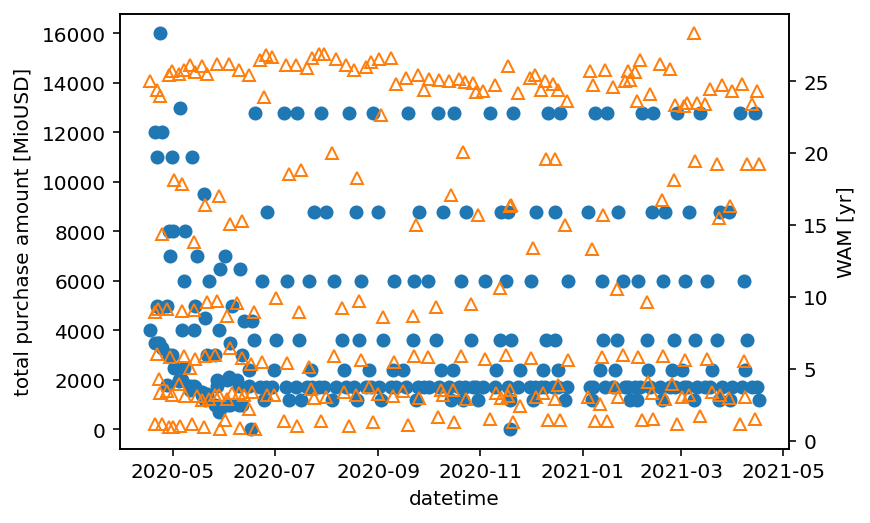

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(operations_db['datetime'], operations_db['purchase_amount'], 'o')
ax1.set_xlabel('datetime'); ax1.set_ylabel('total purchase amount [MioUSD]')
# ax1.axvline('2020-04-01', color='k', linestyle='dashed')
ax2 = ax1.twinx()
ax2.plot(operations_db['datetime'], operations_db['wam'], '^', color='none', markeredgecolor='C1', alpha=1)
ax2.set_ylabel('WAM [yr]')
# ax1.set_xlim("2020-01-01", "2020-12-31")

# 買入金額とWAMの関係

Text(0, 0.5, 'total purchase amount [MioUSD]')

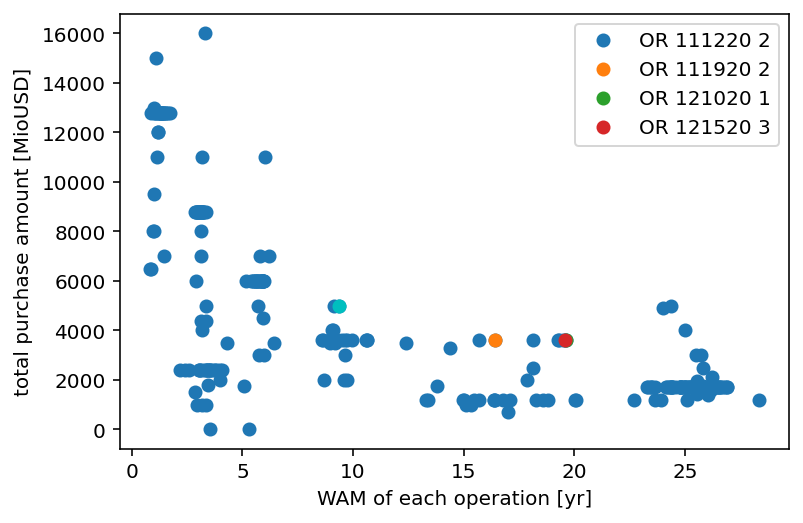

In [ ]:
plt.plot(operations_db['wam'], operations_db['purchase_amount'], 'o')
plt.plot(operations_db.iloc[-1]['wam'], operations_db.iloc[-1]['purchase_amount'], 'co')
for io, opeid in enumerate(['OR 111220 2', 'OR 111920 2', 'OR 121020 1', 'OR 121520 3']):
    plt.plot(operations_db[operations_db.index == opeid]['wam'],
             operations_db[operations_db.index == opeid]['purchase_amount'],
             'o', color=f'C{io%10}', label=opeid)
plt.legend()
plt.xlabel('WAM of each operation [yr]'); plt.ylabel('total purchase amount [MioUSD]')

# 各オペの残存年限ごと買入量の積上げ棒グラフ

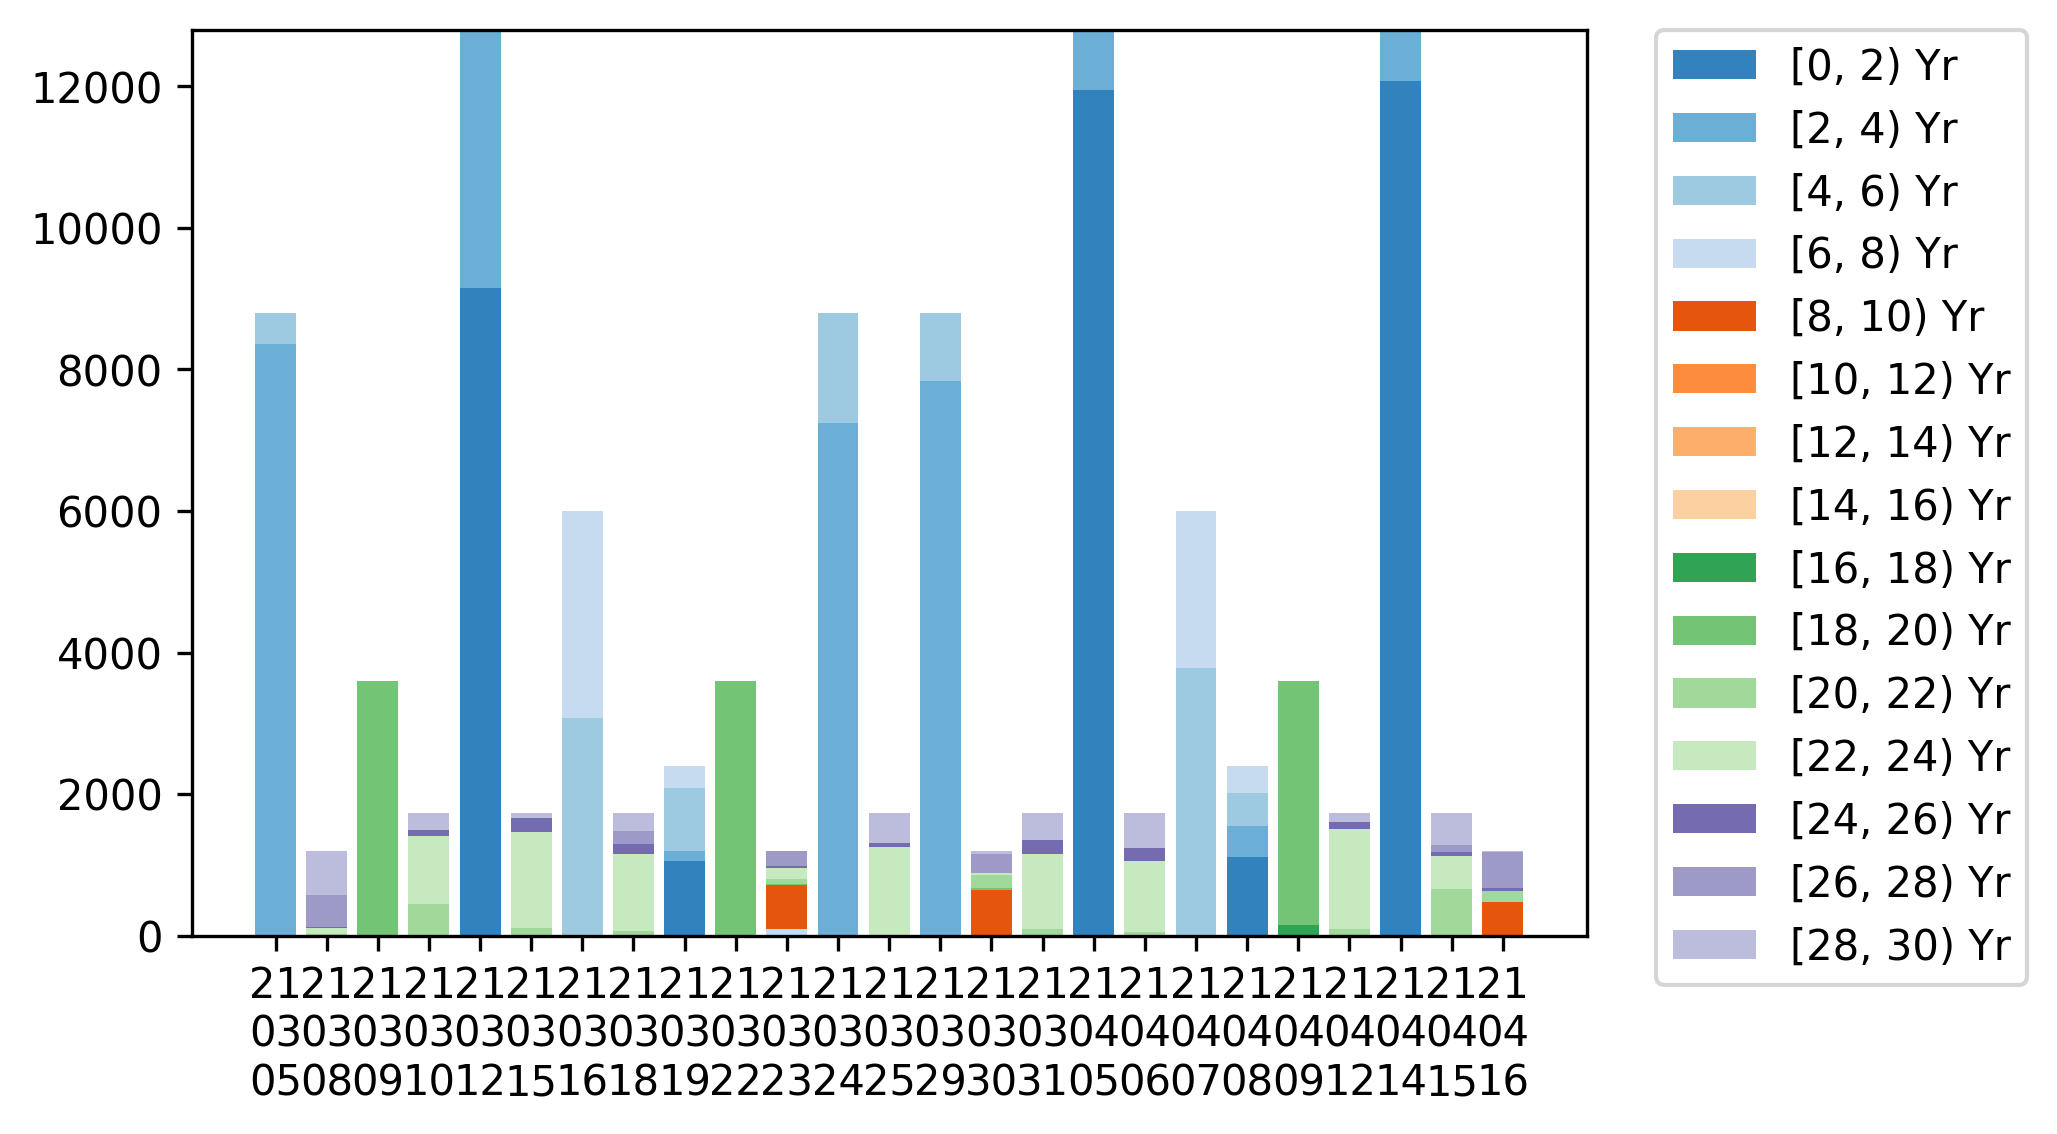

In [ ]:
# 積み上げ棒グラフ作りたい
cmap = plt.get_cmap("tab20c") # ココがポイント
opeids = operations_db.head(25).index
opedate_for_xticklabel = []
for io, opeid in enumerate(opeids[::-1]):
    opedate = operations_db[operations_db.index == opeid]['datetime'][0]
    opedate_for_xticklabel.append(opedate.strftime('%y\n%m\n%d'))
    tmpdf = purchased_treasuries[purchased_treasuries.opeid == opeid].assign(
        remain_to_maturity = lambda df: (df['maturity'] - opedate).astype('timedelta64[M]') / 12
    )
    cuts = pd.cut(tmpdf['remain_to_maturity'], np.arange(0, 32, 2), 
                  include_lowest=True, right=False)
    table_by_RemainToMaturity = tmpdf.groupby(cuts).sum()
    for ir, (rangelabel, (amount, trash)) in enumerate(tmpdf.groupby(cuts).sum().iterrows()):
        plt.bar(io, height=table_by_RemainToMaturity.iloc[ir]['amount'],
                bottom=table_by_RemainToMaturity[:ir]['amount'].sum(),
                color=cmap(ir))

# legend用に最後にもう一回同じものを描画
for ir, (rangelabel, (amount, trash)) in enumerate(tmpdf.groupby(cuts).sum().iterrows()):
        plt.bar(io, height=table_by_RemainToMaturity.iloc[ir]['amount'],
                bottom=table_by_RemainToMaturity[:ir]['amount'].sum(),
                color=cmap(ir), label=str(rangelabel)+' Yr')

plt.gca().set_xticks(np.arange(len(opeids)))
plt.gca().set_xticklabels(opedate_for_xticklabel)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.gcf().set_dpi(150)

# 各オペの残存期間ごと買入量　時系列

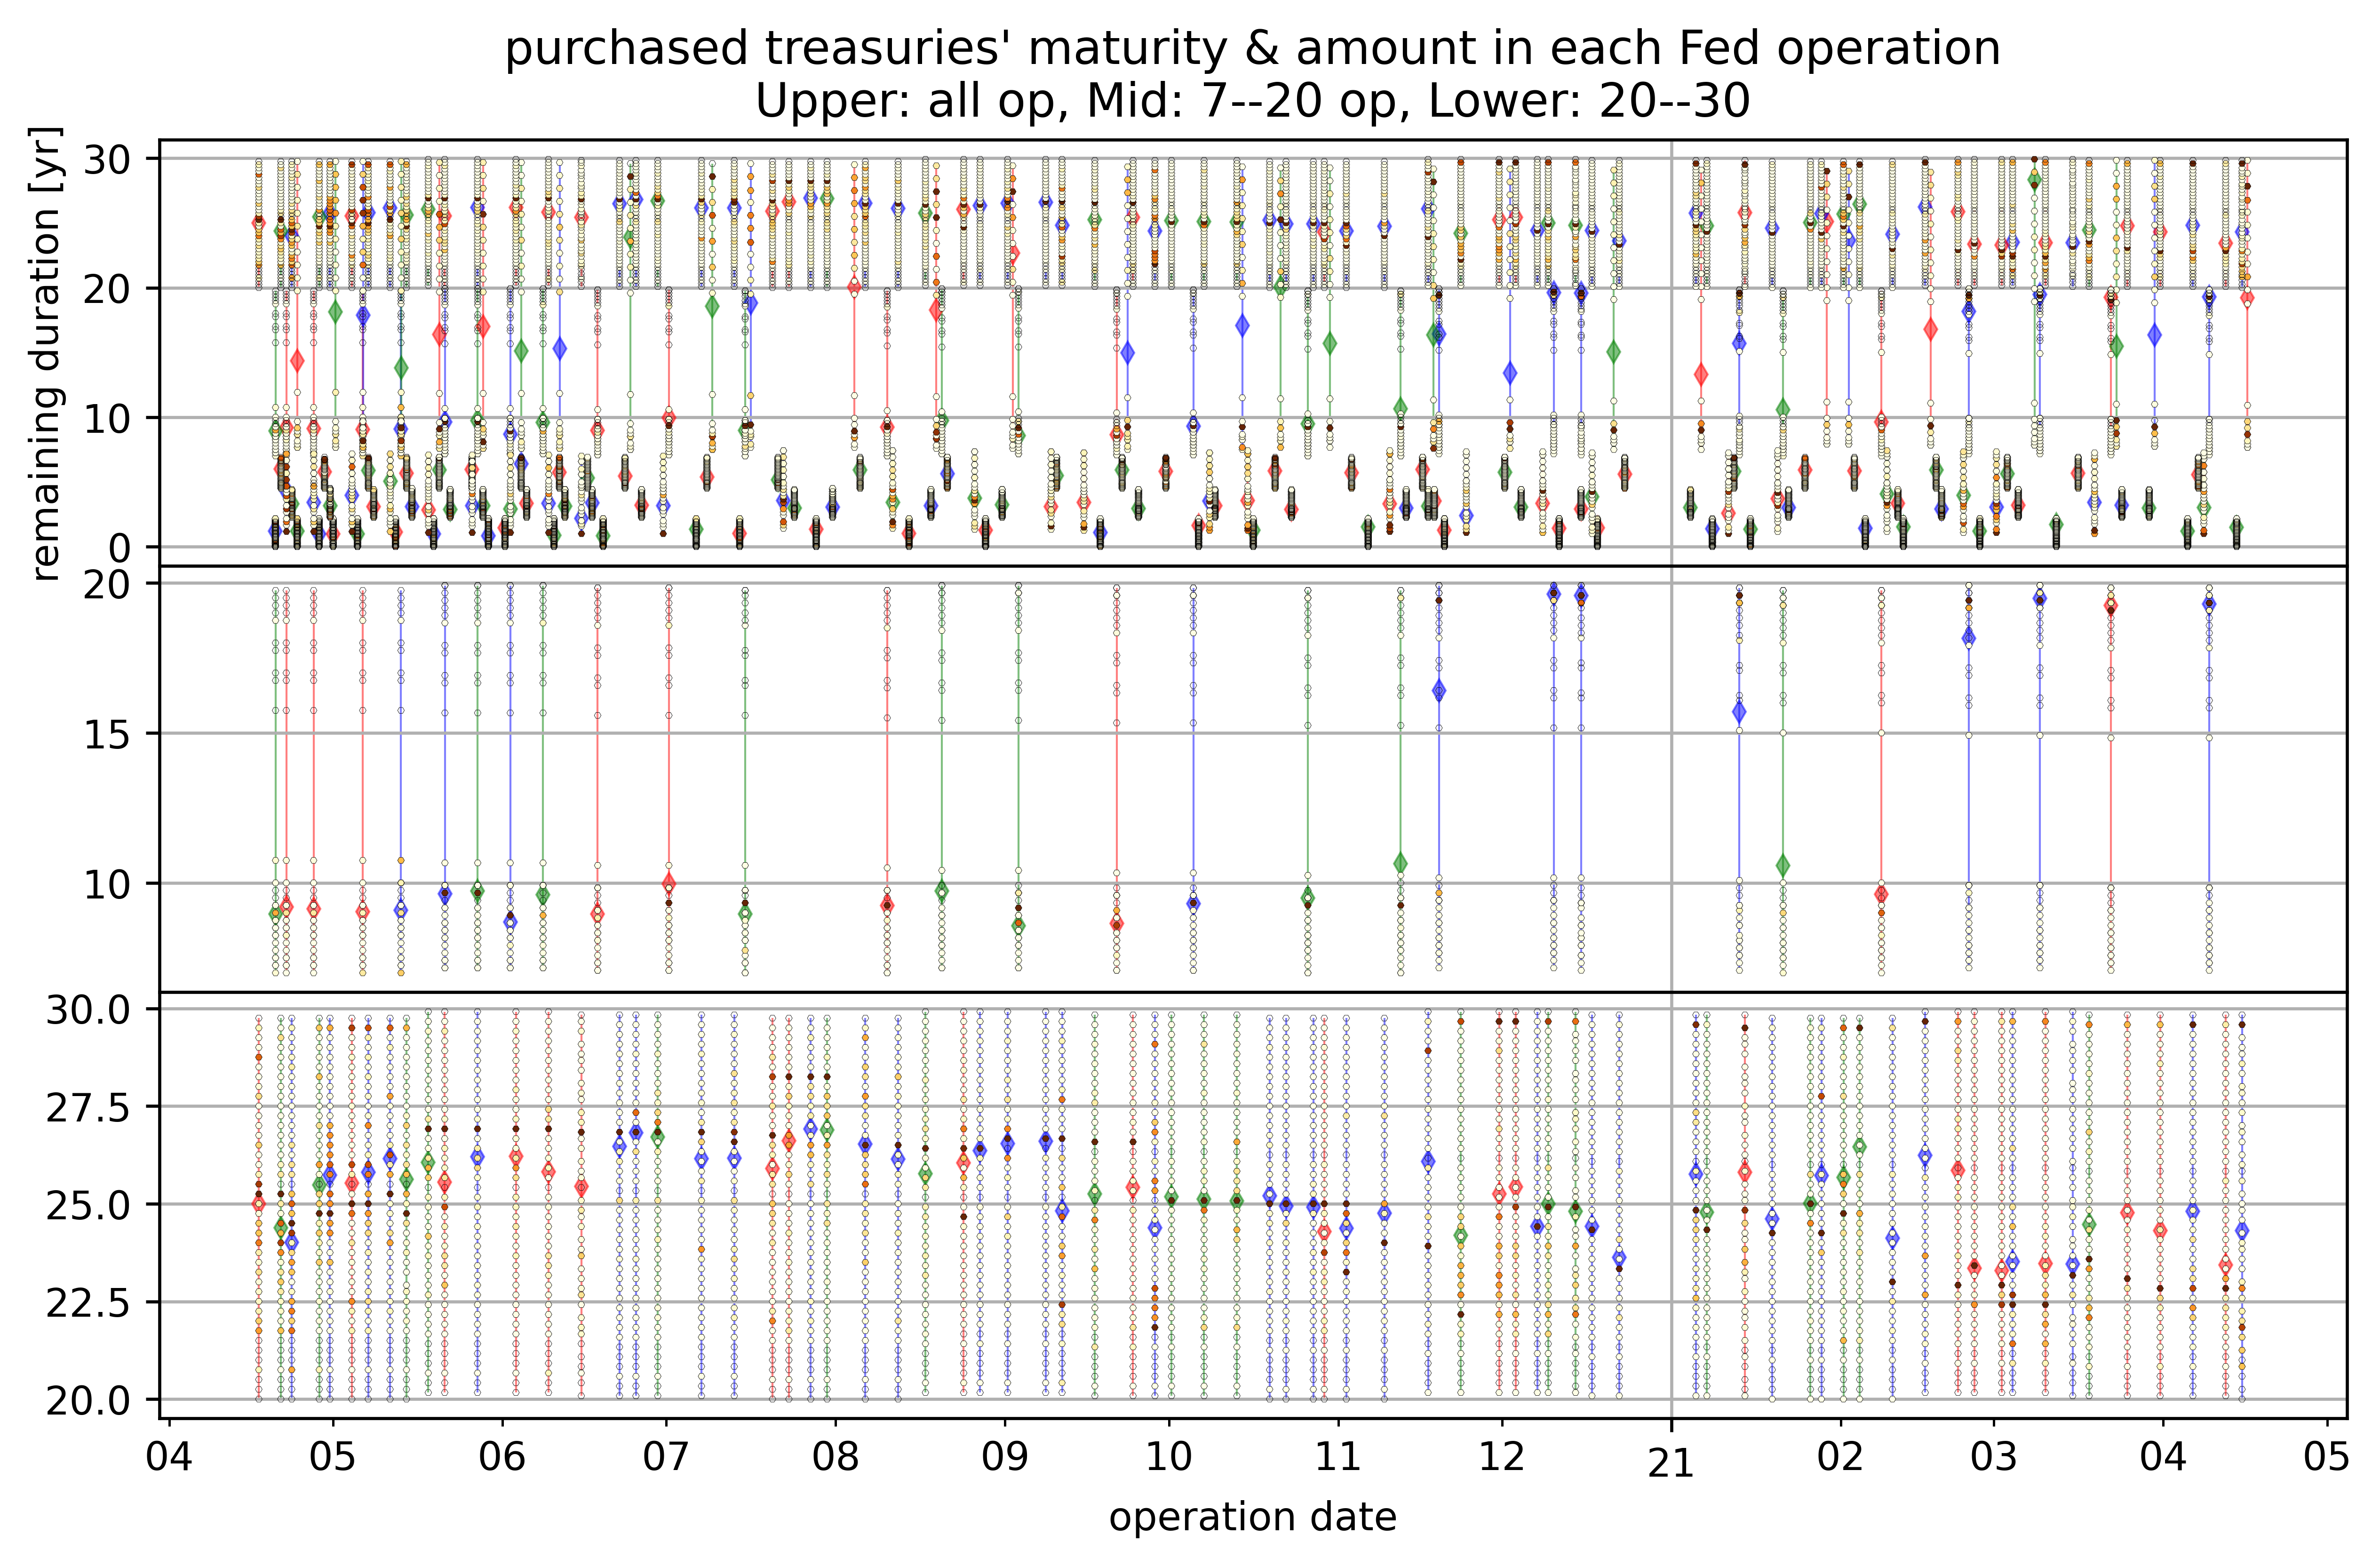

In [ ]:
# オペ実行日-買い入れ残存期間グラフ
fig, ax = plt.subplots(3,1, figsize=(10,6), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0)
fig.set_facecolor('white')
li = 0
for opeid, opedetail in operations_db.iterrows():
    maturity_range = [
        pd.to_timedelta([opedetail['maturity_range_start'] - opedetail['datetime']]).astype('timedelta64[M]') / 12,
        pd.to_timedelta([opedetail['maturity_range_end'] - opedetail['datetime']]).astype('timedelta64[M]') / 12
    ]
    if 6.5 < maturity_range[0] < 7.5 and 19.5 < maturity_range[1] < 20.5:
        axdrawns = [0, 1]
    elif 19.5 < maturity_range[0] < 20.5 and 29.5 < maturity_range[1] < 30.5:
        axdrawns = [0, 2]
    else:
        axdrawns = [0]
    for ia in axdrawns:
        ax[ia].vlines([opedetail['datetime']], 
                  ymin=maturity_range[0], ymax=maturity_range[1],
                  # ymin=pd.to_timedelta([opedetail['maturity_range_start'] - opedetail['datetime']]).astype('timedelta64[M]') /12,
                  # ymax=pd.to_timedelta([opedetail['maturity_range_end'] - opedetail['datetime']]).astype('timedelta64[M]') /12,
                  linewidth=0.5, color=['red', 'blue', 'green'][li%3],
                  alpha=0.5, zorder=1)
        ax[ia].plot(opedetail['datetime'], opedetail['wam'], 'd', 
                color=['red', 'blue', 'green'][li%3], markersize=4, markeredgewidth=0.5, alpha=0.5, zorder=2)
    remaining_duration = purchased_treasuries[purchased_treasuries.opeid == opeid]['maturity'] - opedetail['datetime']
    remaining_duration = remaining_duration.astype('timedelta64[M]') / 12
    remaining_duration = pd.Series(remaining_duration, name='remaining_duration')
    num_purchased_tresuries = len(remaining_duration)
    amount_each_purchased = purchased_treasuries[purchased_treasuries.opeid == opeid]['amount']
    tmp_df = pd.concat([
        pd.Series([opedetail['datetime'] for i in range(num_purchased_tresuries)], 
                  index=purchased_treasuries[purchased_treasuries.opeid == opeid].index, name='opedatetime'),
        remaining_duration, amount_each_purchased
    ], axis=1)
    for ia in axdrawns:
        img = ax[ia].scatter(tmp_df['opedatetime'].values, tmp_df['remaining_duration'], 
                         c=tmp_df['amount'], cmap='YlOrBr', edgecolors='k', linewidths=0.1,
                         alpha=1, s=3, marker='H', zorder=3)
    li += 1
# fig.colorbar(img)
ax[2].set_xlabel('operation date')
ax[0].set_ylabel('remaining duration [yr]')
ax[0].set_title('purchased treasuries\' maturity & amount in each Fed operation\nUpper: all op, Mid: 7--20 op, Lower: 20--30')


# 時刻軸のフォーマット
months = mdates.MonthLocator()
years = mdates.YearLocator() 
month_fmt = mdates.DateFormatter('%m')
year_fmt = mdates.DateFormatter('%y')
for ia in range(3):
    ax[ia].xaxis.set_major_locator(years); ax[ia].xaxis.set_major_formatter(year_fmt)
    ax[ia].xaxis.set_minor_locator(months);
    ax[ia].xaxis.set_minor_formatter(month_fmt)
    ax[ia].grid()

# outstandingに対する購入可能量
各オペ日において、ある満期日を持つ債券の全outstanding額に対して、SOMA holdingがどれくらいあるか